# VGG-16

Importation du modèle VGG-16


In [1]:
import os
%cd
from keras.applications.vgg16 import VGG16,preprocess_input

model = VGG16( include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              classifier_activation='softmax'
             ) # Création du modèle VGG-16 implementé par Keras


/home/fedecabre


/home/fedecabre


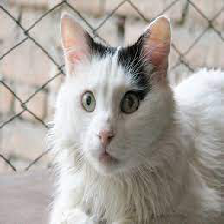

In [2]:
%cd
# à la racine pour avoir accès aux datas
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

project_path ='Documents/OC_Ingenieur_ML/P6_Classez_des_images/'
img = load_img(project_path+'data/cat.jpeg', target_size=(224, 224))  # Charger l'image
display(img)

img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [5]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02124075', 'Egyptian_cat', 0.25156984), ('n02127052', 'lynx', 0.19743551), ('n01877812', 'wallaby', 0.16383485)]


# Transfert Learning


## Création du dataset

In [6]:
import os
import numpy as np
import imageio
from xml.dom import minidom
from PIL import Image

def make_dataset_race(folder,image_size=224, num_channels = 3,preprocess=True):
    image_files=os.listdir(project_path+folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = project_path+folder+'/'+image
        image_data = imageio.imread(image_file)
        if image_data.shape[2]==num_channels: # on prend que les images avec 3 channels
            annon_file = project_path+'data/Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]

            #bounding carré rempli de noir
            x = xmax-xmin
            y = ymax-ymin
            if x<y:
                squarre_image = np.zeros((y,y,num_channels))
                delta = ((y-x)//2)
                squarre_image[:new_image_data.shape[0],delta:(new_image_data.shape[1])+delta,:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)
            if x>y:
                squarre_image = np.zeros((x,x,num_channels))
                delta = ((x-y)//2)
                squarre_image[delta:(new_image_data.shape[0]+delta),:new_image_data.shape[1],:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)

            new_image = Image.fromarray(squarre_image)
            new_image = new_image.resize(size=(image_size,image_size))
            crop_dir = project_path+'data/Cropped/'+ folder.split('/')[-1]
            if os.path.exists(project_path+'data/Cropped/') is False:
                os.mkdir(project_path+'data/Cropped/')
            if os.path.exists(crop_dir) is False:
                os.mkdir(crop_dir)
            #new_image.save(crop_dir+'/'+image)  # Enregistrer les images cropés
            if preprocess:
                dataset[num_images, :, :, :] = preprocess_input(np.array(new_image,dtype='float32'))
            else:
                dataset[num_images, :, :, :] = np.array(new_image,dtype='float32')
            num_images = num_images + 1
    dataset = dataset[0:num_images, :, :, :]
    print('Full dataset tensor:', dataset.shape)
    return dataset


In [7]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.zeros((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.zeros((nb_rows,), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [8]:
images_folders_path = "data/Images/"
images_folders=os.listdir(project_path+images_folders_path)

num_classes = 5 #len(images_folders)
train_size  = 500
valid_size  = 250
image_size  = 224 # 90 ça fonctionne pour whitenning
num_channels= 3
preprocess = False

# Création des datasets vides
valid_dataset, valid_labels = make_arrays(valid_size, image_size)
train_dataset, train_labels = make_arrays(train_size, image_size)


vsize_per_class = valid_size // num_classes # il peut être NULL
tsize_per_class = train_size // num_classes

start_v, start_t = 0, 0
end_v, end_t = vsize_per_class, tsize_per_class
end_l = vsize_per_class+tsize_per_class

# make a dictionary
dog_race_dict = dict()

for label,folder in enumerate(images_folders):
    if label < num_classes :
        print(str(label+1)+'/'+str(num_classes)+' - '+folder.split('-')[-1])
        dog_race_dict[folder.split('-')[-1]] = label
        dataset_race = make_dataset_race('data/Images/'+folder,image_size=image_size,preprocess=preprocess)
        train_breed = dataset_race[vsize_per_class:end_l, :, :, :]
        train_dataset[start_t:end_t, :, :, :] = train_breed
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
        if valid_dataset is not None:
            valid_breed = dataset_race[:vsize_per_class, :, :, :]
            valid_dataset[start_v:end_v, :, :, :] = valid_breed
            valid_labels[start_v:end_v] = label
            start_v += vsize_per_class
            end_v += vsize_per_class

dog_race_invert_dict = {v: k for k, v in dog_race_dict.items()}

1/5 - Bedlington_terrier
Full dataset tensor: (182, 224, 224, 3)
2/5 - collie
Full dataset tensor: (153, 224, 224, 3)
3/5 - Greater_Swiss_Mountain_dog
Full dataset tensor: (168, 224, 224, 3)
4/5 - bull_mastiff
Full dataset tensor: (156, 224, 224, 3)
5/5 - flat_coated_retriever
Full dataset tensor: (152, 224, 224, 3)


In [9]:
dog_race_dict

{'Bedlington_terrier': 0,
 'collie': 1,
 'Greater_Swiss_Mountain_dog': 2,
 'bull_mastiff': 3,
 'flat_coated_retriever': 4}

In [10]:
print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)

(500, 224, 224, 3)
(500,)
(250, 224, 224, 3)
(250,)


In [11]:
#train_labels_one_hot = np.zeros((train_labels.size, train_labels.max()+1))
#train_labels_one_hot[np.arange((train_labels.size),train_labels)]=1
#train_labels_one_hot.shape

from keras.utils.np_utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
valid_labels_categorical = to_categorical(valid_labels, num_classes=num_classes)
print(train_labels_categorical.shape)
print(valid_labels_categorical.shape)

(500, 5)
(250, 5)


In [12]:
#on garde une copie du dataset pour l'utiliser pour le whitening
train_dataset_white = train_dataset.copy()
valid_dataset_white = valid_dataset.copy()
train_dataset_CLAHE = train_dataset.copy()
valid_dataset_CLAHE = valid_dataset.copy()

In [13]:
# on traite les datasets avec le preproces de VGG16
preprocess_input(train_dataset)
preprocess_input(valid_dataset)

array([[[[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        ...,

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -1

## Whitening entraînement

In [14]:
from skimage.transform import resize

def zca_whitening_dataset(X,subset,factor=4,make_matrix=True,U=None,S=None,V=None):
    """
    Function to compute ZCA whitening in an array of images (aka Mahalanobis whitening).
    INPUT:  X: [N,img_len,img_len,channels] matrix.
            subset : numbers of elements of X to use in calculation
            factor : in order to be able to make the calculation in limited RAM the images are resized
            make_matrix : if the U, S and V matrix are already calculated
    OUTPUT: X_ZCA_rescaled_resized: [N,img_len,img_len,channels] matrix with the same shape of X
            U: [M x M] eigenvectors of sigma.
            S: [M x 1] eigenvalues of sigma.
            V: [M x M] transpose of U 
    """
    print(X.shape)
    X = X[:subset]
    print(X.shape)
    
    # reduction de dimension pour que le calcul puisse se faire avec 16 Gb de RAM
    X_resized = np.zeros((X.shape[0],X.shape[1]//factor,X.shape[2]//factor,X.shape[3]))
    for i in range(len(X)):
        X_resized[i] = resize(X[i], (X.shape[1]//factor,X.shape[2]//factor))
    print(X_resized.shape)
    X_resized = X_resized.reshape(X_resized.shape[0], 
                                  X_resized.shape[1]*X_resized.shape[2]*X_resized.shape[3])
    print(X_resized.shape)
    print( 'X.min()', X_resized.min())
    print( 'X.max()', X_resized.max())
    X_resized_norm = X_resized / 255
    print( 'X.min()', X_resized_norm.min())
    print( 'X.max()', X_resized_norm.max())
    
    X_resized_norm.mean(axis=0).shape #This gives us values which is the number of means — one per pixel.
    X_resized_norm = X_resized_norm - X_resized_norm.mean(axis=0)
    X_ZCA_rescaled_resized = np.zeros(X.shape)
    if make_matrix:
        cov = np.cov(X_resized_norm, rowvar=False) # it will use the columns as variables (or features) and the rows as observations.
        print(cov.shape)

        U,S,V = np.linalg.svd(cov)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
        print(U.shape, S.shape)

        # elargir les matrices pour transformer les images
        U = U.astype('float32')
        S = S.astype('float32')
        V = V.astype('float32')
        
        print (U.shape)

        U = U.reshape(X.shape[1]//factor,
                      X.shape[2]//factor,
                      X.shape[3],
                      X.shape[1]//factor,
                      X.shape[2]//factor,
                      X.shape[3]
                     )
        
        S = S.reshape(X.shape[1]//factor,
                      X.shape[2]//factor,
                      X.shape[3]
                     )                     
        
        # elargir les matrices pour transformer les images
        U = np.repeat(np.repeat(np.repeat(np.repeat(U, 2, axis=4), 2, axis=3), 2, axis=1), 2, axis=0)
        S = np.repeat(np.repeat(S, 2, axis=1), 2, axis=0)
        
        U = U.reshape(X.shape[1]//factor*2*X.shape[2]//factor*2*X.shape[3],
                      X.shape[1]//factor*2*X.shape[2]//factor*2*X.shape[3]
                     )
        
        S = S.reshape(X.shape[1]//factor*2*X.shape[2]//factor*2*X.shape[3]
                     ) 
        # Imposible MemoryError: Unable to allocate 169. GiB for an array with shape (150528, 150528) and data type float64
        np.save(project_path+'models/U_matrix.npy', U)
        np.save(project_path+'models/S_matrix.npy', S)
    
    else :
        
        # Whitening constant: prevents division by zero
        epsilon = 1e-5

        # ZCA Whitening matrix: U * Lambda * U'
        X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_resized_norm.T).T 
        X_ZCA_rescaled = ((X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min()))*255
        print(X_ZCA_rescaled.shape)
        X_ZCA_rescaled = X_ZCA_rescaled.reshape(X.shape[0],
                                                X.shape[1]//2,
                                                X.shape[2]//2,
                                                X.shape[3])
        print(X_ZCA_rescaled.shape)
        
        for i in range(len(X)):
            X_ZCA_rescaled_resized[i] = resize(X_ZCA_rescaled[i], (X.shape[1],X.shape[2]))
        print('min:', X_ZCA_rescaled_resized.min())
        print('max:', X_ZCA_rescaled_resized.max())
    return X_ZCA_rescaled_resized,U,S

In [15]:
# Géneration de la matrice --> 10 minutes de calcul
# matrice enregistré dans le disque pour gagner du temps
#_ ,U,S = zca_whitening_dataset(train_dataset_white.astype('float32'),1000,factor=4)

# Modèle VGG-16

## Fonction métriques

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
def min_loss_max_acc(model_info):
    loss_min = min(model_info.history['val_loss'])
    loss_min_epoch = model_info.history['val_loss'].index(loss_min)+1
    acc_max = max(model_info.history['val_accuracy'])
    acc_max_epoch = model_info.history['val_accuracy'].index(acc_max)+1
    return np.round(loss_min,decimals=5), loss_min_epoch, np.round(acc_max,decimals=5), acc_max_epoch

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
def clas_report(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    # Classification Report
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    print('Classification Report')
    print(classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys()))

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def conf_matr(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                      columns = [i for i in dog_race_dict.keys()])
    plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    sn.heatmap(df_cm, annot=True)

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score(model,valid_dataset, valid_labels, labels,dog_race_dict=dog_race_dict, average="macro"):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8),)
    fig.patch.set_facecolor('w')
    lb = LabelBinarizer()
    lb.fit(valid_labels)
    y_test = lb.transform(valid_labels)
    y_pred = lb.transform(valid_labels_pred)

    for (idx, c_label) in enumerate(labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

## Fonctions d'affichage

In [21]:
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(project_path, "Graphs")
os.makedirs(IMAGES_PATH, exist_ok=True)

IMAGES_PATH = project_path + "Graphs/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [22]:
import matplotlib.pyplot as plt

def plot_loss(model_info,graph_name,loss_min,tight_layout=True, fig_extension="png", resolution=300):
    loss = model_info.history['loss']
    val_loss = model_info.history['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.axvline(x=loss_min,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

In [23]:
plt.clf()   # clear figure

def plot_accuracy(model_info,graph_name,acc_max,tight_layout=True, fig_extension="png", resolution=300):
    acc_train = model_info.history['accuracy']
    acc_val = model_info.history['val_accuracy']
    
    epochs = range(1, len(acc_train) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, acc_train, 'bo', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.axvline(x=acc_max,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
def plotImage(X):
    plt.figure(figsize=(6, 6))
    plt.imshow(X.reshape(image_size,image_size,3))
    plt.axis('off')
    plt.show()
    plt.close()

## Modèle CNN classique

### modèle

In [25]:
from functools import partial
from keras import layers
from keras.models import Sequential
from keras import Model

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=num_classes, activation='softmax'),
])

In [26]:
# Compiler le modèle
model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       5

### Entraînement

In [27]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model0_info = model.fit(train_dataset/255,train_labels_categorical,
                           epochs=70,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset/255,valid_labels_categorical)
                           )

Epoch 1/70
16/16 [==============================] - 25s 1s/step - loss: 1.7722 - accuracy: 0.1980 - f1_m: 0.0121 - precision_m: 0.0714 - recall_m: 0.0098 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/70
16/16 [==============================] - 6s 395ms/step - loss: 1.6102 - accuracy: 0.1800 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/70
16/16 [==============================] - 6s 392ms/step - loss: 1.6098 - accuracy: 0.1920 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/70
16/16 [==============================] - 6s 394ms/step - loss: 1.6098 - accuracy: 0.1760 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00

16/16 [==============================] - 7s 448ms/step - loss: 1.6100 - accuracy: 0.1880 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6094 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/70
16/16 [==============================] - 7s 449ms/step - loss: 1.6092 - accuracy: 0.2120 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 31/70
16/16 [==============================] - 7s 449ms/step - loss: 1.6102 - accuracy: 0.1840 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/70
16/16 [==============================] - 7s 449ms/step - loss: 1.6104 - accuracy: 0.2120 - f1_m: 0.0000e+00 - precision_m: 0.00

16/16 [==============================] - 7s 444ms/step - loss: 1.6108 - accuracy: 0.2040 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6094 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 58/70
16/16 [==============================] - 7s 444ms/step - loss: 1.6090 - accuracy: 0.2220 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6094 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 59/70
16/16 [==============================] - 7s 443ms/step - loss: 1.6101 - accuracy: 0.1720 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 60/70
16/16 [==============================] - 7s 442ms/step - loss: 1.6092 - accuracy: 0.2000 - f1_m: 0.0000e+00 - precision_m: 0.00

### Résultats

Saving figure model0 val_loss min=0.33618 training_and_validation_accuracy-num_classes=2-train_size=200-valid_size=100-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

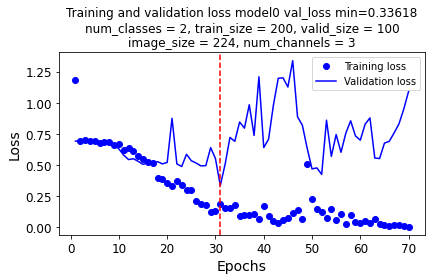

Saving figure model0 val_acc_max=0.9 training_and_validation_accuracy-num_classes=2-train_size=200-valid_size=100-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

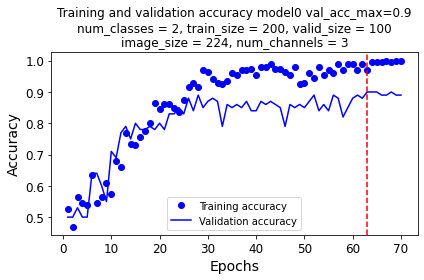

In [60]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model0_info)
plot_loss(model0_info,'model0 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model0_info,'model0 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


Saving figure model0 val_loss min=1.60944 training_and_validation_accuracy-num_classes=5-train_size=500-valid_size=250-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

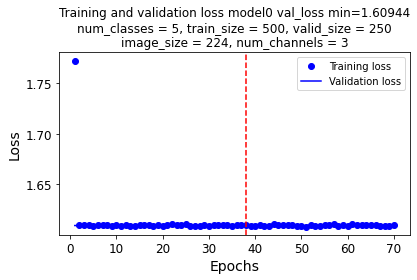

Saving figure model0 val_acc_max=0.2 training_and_validation_accuracy-num_classes=5-train_size=500-valid_size=250-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

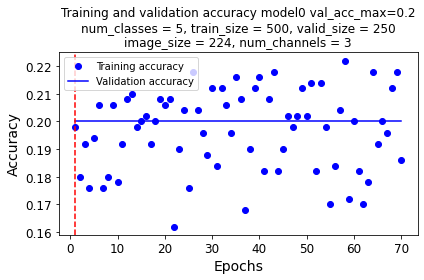

In [28]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model0_info)
plot_loss(model0_info,'model0 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model0_info,'model0 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


## Stratégie fine tunning partiel

### modèle

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
F = Flatten()(x)
DL1 = Dense(30)(F)
DL2 = Dense(30)(DL1)
predictions = Dense(num_classes, activation='softmax')(DL2)

# Stratégie #2 : extraction de features
for layer in model.layers:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [ ]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])

new_model.summary()

### Entraînement

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model1_info = new_model.fit(train_dataset,train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

### Résultats

In [ ]:
loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model1_info)
plot_loss(model1_info,'model1 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


In [ ]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model1_info)
plot_accuracy(model1_info,'model1 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [ ]:
clas_report(new_model,valid_dataset,valid_labels)

In [ ]:
conf_matr(new_model,valid_dataset,valid_labels)

In [ ]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Stratégie extraction des features (model 2)

### Modèle

In [26]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(image_size, image_size, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [27]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])
new_model.save_weights('model.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Entraînement

In [28]:
%time
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit(preprocess_input(train_dataset),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(preprocess_input(valid_dataset),valid_labels_categorical)
                           )

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 21.5 µs
Epoch 1/10
32/32 [==============================] - 27s 598ms/step - loss: 0.5090 - accuracy: 0.8790 - f1_m: 0.8801 - precision_m: 0.8903 - recall_m: 0.8721 - val_loss: 0.0512 - val_accuracy: 0.9860 - val_f1_m: 0.9863 - val_precision_m: 0.9863 - val_recall_m: 0.9863
Epoch 2/10
32/32 [==============================] - 11s 339ms/step - loss: 0.0182 - accuracy: 0.9960 - f1_m: 0.9961 - precision_m: 0.9961 - recall_m: 0.9961 - val_loss: 0.0648 - val_accuracy: 0.9880 - val_f1_m: 0.9883 - val_precision_m: 0.9883 - val_recall_m: 0.9883
Epoch 3/10
32/32 [==============================] - 11s 342ms/step - loss: 0.0016 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9860 - val_f1_m: 0.9863 - val_precision_m: 0.9863 - val_recall_m: 0.9863
Epoch 4/10
32/32 [==============================] - 11s 343ms/step - loss: 4.7596e-04 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m:

### Résultats

In [ ]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max) ,acc_max=acc_max_epoch)

In [ ]:

clas_report(new_model,valid_dataset,valid_labels)

In [ ]:
conf_matr(new_model,valid_dataset,valid_labels)

In [ ]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Whitening (model2)

### reduction dimention du dataset

In [32]:
train_dataset_reduced = np.zeros((train_dataset_white.shape))
train_dataset_temp = np.zeros((train_dataset_white.shape[0],
                              train_dataset_white.shape[1]//2,
                              train_dataset_white.shape[2]//2,
                              train_dataset_white.shape[3]))
for i in range(len(train_dataset)):
        train_dataset_temp[i] = resize(train_dataset_white[i], 
                                       (train_dataset_white.shape[1]//2,
                                        train_dataset_white.shape[2]//2))
        train_dataset_reduced[i] = resize(train_dataset_temp[i], 
                                          (train_dataset_white.shape[1],
                                           train_dataset_white.shape[2]))

In [33]:
valid_dataset_reduced = np.zeros((valid_dataset_white.shape))
valid_dataset_temp = np.zeros((valid_dataset_white.shape[0],
                              valid_dataset_white.shape[1]//2,
                              valid_dataset_white.shape[2]//2,
                              valid_dataset_white.shape[3]))
for i in range(len(valid_dataset)):
        valid_dataset_temp[i] = resize(valid_dataset_white[i], 
                                       (valid_dataset_white.shape[1]//2,
                                        valid_dataset_white.shape[2]//2))
        valid_dataset_reduced[i] = resize(valid_dataset_temp[i], 
                                          (valid_dataset_white.shape[1],
                                           valid_dataset_white.shape[2]))

In [15]:
U = np.load(project_path+'models/U_matrix.npy')
S = np.load(project_path+'models/S_matrix.npy')

### création du dataset avec whitening

In [16]:
ZCA_train_dataset,_,_ = zca_whitening_dataset(train_dataset_white,1000,factor=2,make_matrix=False,U=U,S=S)

(1000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 112, 112, 3)
(1000, 37632)
X.min() 0.0
X.max() 255.0
X.min() 0.0
X.max() 1.0
(1000, 37632)
(1000, 112, 112, 3)
min: 1.2168783415437622e-05
max: 255.0


In [18]:
ZCA_valid_dataset,_,_ = zca_whitening_dataset(valid_dataset_white,500,factor=2,make_matrix=False,U=U,S=S)

(500, 224, 224, 3)
(500, 224, 224, 3)
(500, 112, 112, 3)
(500, 37632)
X.min() 0.0
X.max() 255.0
X.min() 0.0
X.max() 1.0
(500, 37632)
(500, 112, 112, 3)
min: 2.554171151743779e-07
max: 254.99999937320547


In [39]:
train_dataset_white[1, :]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

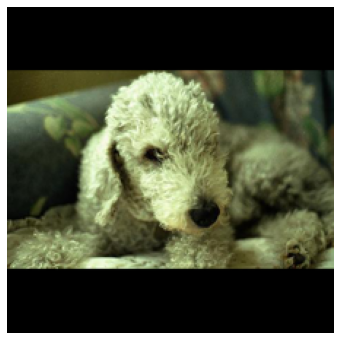

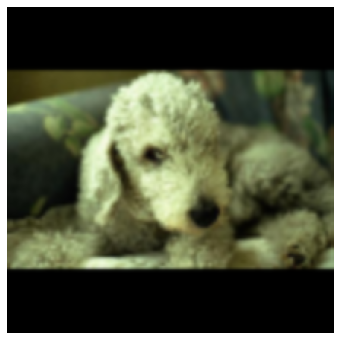

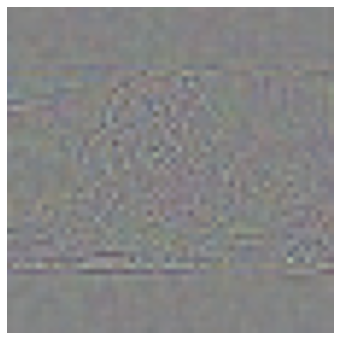

In [35]:
plotImage(train_dataset_white[1, :]/255)
plotImage(train_dataset_reduced[1, :]/255)
plotImage(ZCA_train_dataset[1, :]/255)


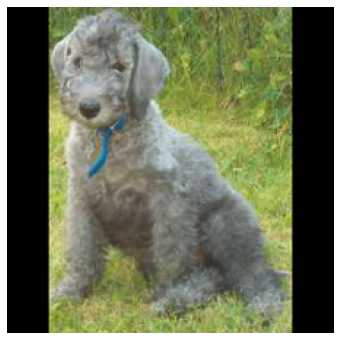

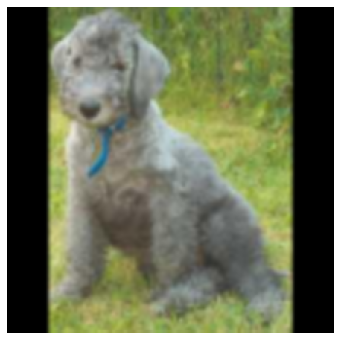

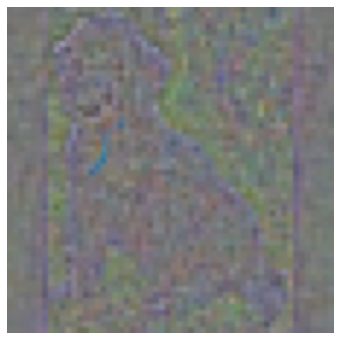

In [37]:
plotImage(valid_dataset_white[1, :]/255)
plotImage(valid_dataset_reduced[1, :]/255)
plotImage(ZCA_valid_dataset[1, :]/255)

In [38]:
preprocess_input(train_dataset_reduced)
preprocess_input(valid_dataset_reduced)

array([[[[-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         ...,
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ]],

        [[-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         ...,
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ]],

        [[-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         ...,
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
  

In [39]:
preprocess_input(ZCA_train_dataset)
preprocess_input(ZCA_valid_dataset)

array([[[[ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         ...,
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882]],

        [[ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         ...,
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882]],

        [[ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         ...,
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882]],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


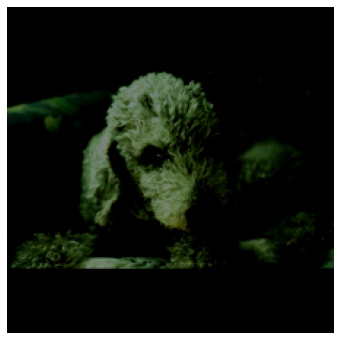

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


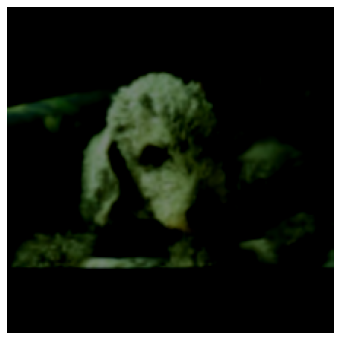

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


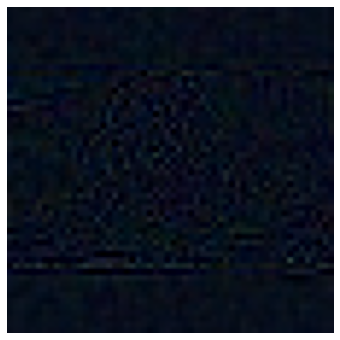

In [40]:
plotImage(train_dataset[1, :]/255)
plotImage(train_dataset_reduced[1, :]/255)
plotImage(ZCA_train_dataset[1, :]/255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


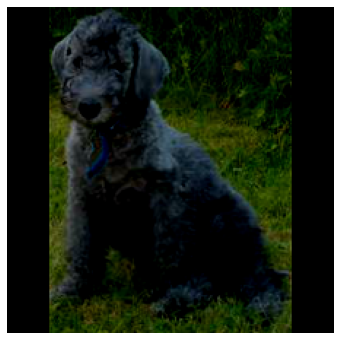

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


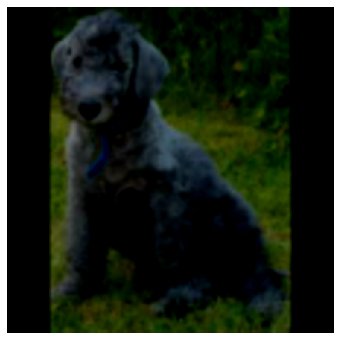

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


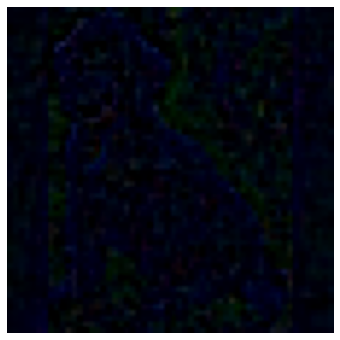

In [41]:
plotImage(valid_dataset[1, :]/255)
plotImage(valid_dataset_reduced[1, :]/255)
plotImage(ZCA_valid_dataset[1, :]/255)

### Entraînement avant whitening

In [42]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_reduced),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_reduced),valid_labels_categorical)
                           )

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.8 µs
Epoch 1/10
32/32 [==============================] - 116s 4s/step - loss: 0.6957 - accuracy: 0.7930 - f1_m: 0.7832 - precision_m: 0.8296 - recall_m: 0.7520 - val_loss: 0.1929 - val_accuracy: 0.9360 - val_f1_m: 0.9352 - val_precision_m: 0.9455 - val_recall_m: 0.9254
Epoch 2/10
32/32 [==============================] - 137s 4s/step - loss: 0.0909 - accuracy: 0.9740 - f1_m: 0.9759 - precision_m: 0.9812 - recall_m: 0.9707 - val_loss: 0.2151 - val_accuracy: 0.9220 - val_f1_m: 0.9177 - val_precision_m: 0.9229 - val_recall_m: 0.9129
Epoch 3/10
32/32 [==============================] - 134s 4s/step - loss: 0.0464 - accuracy: 0.9870 - f1_m: 0.9873 - precision_m: 0.9893 - recall_m: 0.9854 - val_loss: 0.1887 - val_accuracy: 0.9380 - val_f1_m: 0.9423 - val_precision_m: 0.9498 - val_recall_m: 0.9352
Epoch 4/10
32/32 [==============================] - 132s 4s/step - loss: 0.0200 - accuracy: 0.9990 - f1_m: 0.9990 - precision_m: 0.9990 - rec

### Résultat avant whitenning

Saving figure model2 val_loss min=0.1826
images downsizés avant Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

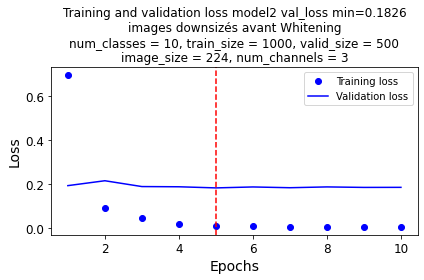

Saving figure model2 val_acc_max=0.938
images downsizés avant Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

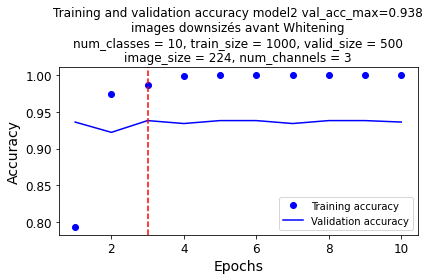

In [43]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images downsizés avant Whitening',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images downsizés avant Whitening',acc_max=acc_max_epoch)

### Entraînement après whitennning

In [44]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((ZCA_train_dataset),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((ZCA_valid_dataset),valid_labels_categorical)
                           )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Epoch 1/10
32/32 [==============================] - 118s 4s/step - loss: 2.9959 - accuracy: 0.1380 - f1_m: 0.0707 - precision_m: 0.1908 - recall_m: 0.0479 - val_loss: 2.9925 - val_accuracy: 0.1680 - val_f1_m: 0.0524 - val_precision_m: 0.2024 - val_recall_m: 0.0309
Epoch 2/10
32/32 [==============================] - 135s 4s/step - loss: 2.3999 - accuracy: 0.2760 - f1_m: 0.1987 - precision_m: 0.4153 - recall_m: 0.1367 - val_loss: 2.9336 - val_accuracy: 0.1500 - val_f1_m: 0.0986 - val_precision_m: 0.1844 - val_recall_m: 0.0680
Epoch 3/10
32/32 [==============================] - 131s 4s/step - loss: 1.9292 - accuracy: 0.3590 - f1_m: 0.2374 - precision_m: 0.5751 - recall_m: 0.1533 - val_loss: 2.6706 - val_accuracy: 0.1780 - val_f1_m: 0.1058 - val_precision_m: 0.1816 - val_recall_m: 0.0766
Epoch 4/10
32/32 [==============================] - 131s 4s/step - loss: 1.8183 - accuracy: 0.3980 - f1_m: 0.2985 - precision_m: 0.5930 - rec

### Résultat après whitening

Saving figure model2 val_loss min=2.6706
images downsizés avec Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

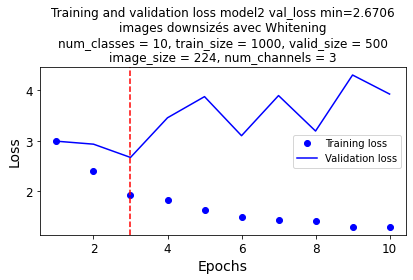

Saving figure model2 val_acc_max=0.182
images downsizés avec Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

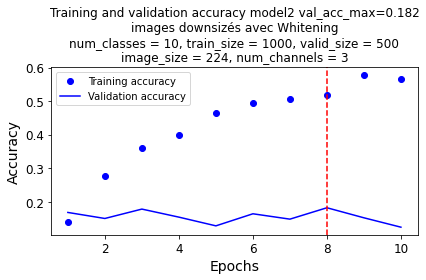

In [45]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images downsizés avec Whitening',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images downsizés avec Whitening',acc_max=acc_max_epoch)

## CLAHE

## Preparation du dataset

In [ ]:
import cv2 as cv

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = (train_dataset_CLAHE[1,:,:,:].astype(np.uint8))

r,g,b = cv.split(img)

img[:,:,0] = clahe.apply(r)
img[:,:,1] = clahe.apply(g)
img[:,:,2] = clahe.apply(b)


plotImage((train_dataset_white[1,:,:,:].astype(np.uint8)))
plotImage(img)

In [ ]:
import cv2 as cv

img = (train_dataset_CLAHE[1,:,:,:].astype(np.uint8))

r,g,b = cv.split(img)

img[:,:,0] = cv.equalizeHist(r)
img[:,:,1] = cv.equalizeHist(g)
img[:,:,2] = cv.equalizeHist(b)

img.shape
plotImage((train_dataset_white[1,:,:,:].astype(np.uint8)))
plotImage(img)

In [ ]:
import cv2 as cv

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

train_dataset_EQUA =train_dataset_CLAHE.copy()
valid_dataset_EQUA = valid_dataset_CLAHE.copy()

for i in range(train_dataset_CLAHE.shape[0]):

    img = (train_dataset_CLAHE[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    train_dataset_CLAHE[i,:,:,0] = clahe.apply(r)
    train_dataset_CLAHE[i,:,:,1] = clahe.apply(g)
    train_dataset_CLAHE[i,:,:,2] = clahe.apply(b)
    
for i in range(valid_dataset_CLAHE.shape[0]):

    img = (valid_dataset_CLAHE[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    valid_dataset_CLAHE[i,:,:,0] = clahe.apply(r)
    valid_dataset_CLAHE[i,:,:,1] = clahe.apply(g)
    valid_dataset_CLAHE[i,:,:,2] = clahe.apply(b)

preprocess_input(train_dataset_CLAHE)
preprocess_input(valid_dataset_CLAHE)

In [ ]:
import cv2 as cv



for i in range(train_dataset_EQUA.shape[0]):

    img = (train_dataset_EQUA[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    train_dataset_EQUA[i,:,:,0] = clahe.apply(r)
    train_dataset_EQUA[i,:,:,1] = clahe.apply(g)
    train_dataset_EQUA[i,:,:,2] = clahe.apply(b)
    
for i in range(valid_dataset_EQUA.shape[0]):

    img = (valid_dataset_EQUA[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    valid_dataset_EQUA[i,:,:,0] = clahe.apply(r)
    valid_dataset_EQUA[i,:,:,1] = clahe.apply(g)
    valid_dataset_EQUA[i,:,:,2] = clahe.apply(b)

preprocess_input(train_dataset_EQUA)
preprocess_input(valid_dataset_EQUA)

## Entraînement et résultats du modèle CLAHE

In [ ]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_CLAHE),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_CLAHE),valid_labels_categorical)
                           )

In [ ]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images avec CLAHE',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images images avec CLAHE',acc_max=acc_max_epoch)

## Entraînement et résultats du modèle EQUA

In [ ]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_EQUA),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_EQUA),valid_labels_categorical)
                           )

In [ ]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images avec EQUALISATION',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images images avec EQUALISATION',acc_max=acc_max_epoch)

## Ajout de data augmentation

### Exemple

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_chien = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   #preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

In [ ]:
import tensorflow as tf

folder = 'data/Images/n02085620-Chihuahua'
dataset_chien = make_dataset_race(folder,preprocess=False)
image = dataset_chien[1,:,:,:]/255
#datagen_chien.fit(tf.expand_dims(image, 0))
print( 'Photo avant et après preprocess pour le modèle VGG-16')
plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 1)
plt.imshow(image)
ax = plt.subplot(3, 3, 2)
plt.imshow(preprocess_input(image*255))
plt.figure(figsize=(10, 10))
plt.axis('off')
print( 'Exemple de Data Aumentation')
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = datagen_chien.flow(tf.expand_dims(image, 0), batch_size=1)
    plt.imshow(augmented_image[0][0])
    plt.axis('off')



### Générateur

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=20,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(train_dataset) # pas nécessaire car les images sont déjà préprocessés


### Entraînement

In [ ]:
# reset the weights
new_model.load_weights('model.h5')

# fits the model on batches with real-time data augmentation:
model2da_info = new_model.fit(datagen.flow(train_dataset, 
                                           train_labels_categorical, 
                                           batch_size=32),
                                initial_epoch=0,
                                validation_data=(valid_dataset, valid_labels_categorical),
                                steps_per_epoch=32,
                                epochs=15)

### Résultats model 2 avec Data Aumentation

In [ ]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2da_info)
plot_loss(model2da_info,'model2 avec DA val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2da_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)

In [ ]:

clas_report(new_model,valid_dataset,valid_labels)

In [ ]:
conf_matr(new_model,valid_dataset,valid_labels)

In [ ]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

# Entrainement sur toutes les classes avec DA

## Création du générateur de données

In [31]:
from keras.preprocessing.image import ImageDataGenerator

crop_images_folders_path = project_path+"data/Cropped/"
image_size = 224
num_channels = 3

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.1,
                             rotation_range=20,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )

train_generator = datagen.flow_from_directory(crop_images_folders_path,
                                                target_size=(image_size, image_size),
                                                batch_size=32,
                                                subset="training",
                                                class_mode='categorical')

validation_generator = datagen.flow_from_directory(crop_images_folders_path,
                                                   target_size=(image_size, image_size),
                                                   batch_size=32,
                                                   subset="validation",
                                                   class_mode='categorical')
num_classes = train_generator.num_classes
train_size = train_generator.n
valid_size = validation_generator.n

Found 18570 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.


## Modèle avec nombre de classes 120

In [32]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [33]:
import tensorflow as tf
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  #metrics=["accuracy",f1_m,precision_m,recall_m])
                  metrics=["accuracy"])

new_model.load_weights(project_path+'models/model120_weights.h5')
new_model.save(project_path+'models/model120.h5')
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## entraînement

In [ ]:
model2_120_info = new_model.fit(train_generator,
                                validation_data=validation_generator,
                                initial_epoch=0,
                                steps_per_epoch=64,
                                epochs=50)

## Résultats

In [ ]:

loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model2_120_info)
plot_loss(model2_120_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


In [ ]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model2_120_info)
plot_accuracy(model2_120_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [38]:
validation_generator2 = datagen.flow_from_directory(crop_images_folders_path,
                                                   target_size=(image_size, image_size),
                                                   batch_size=1500,
                                                   subset="validation",
                                                   class_mode='categorical')

(images,labels) = next(validation_generator2)

Found 2009 images belonging to 120 classes.


In [49]:
labels2=np.zeros(labels.shape[0])
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j]==1:
            labels2[i]=j
            
# tester Argmax 

In [ ]:

clas_report(new_model,images,labels2,validation_generator.class_indices)

In [ ]:
conf_matr(new_model,images,labels2,validation_generator.class_indices)

In [ ]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         images,
                         labels2,
                         validation_generator.class_indices.keys(),
                         validation_generator.class_indices,
                         average="macro")
     )

## Fine tunning

In [34]:
for layer in new_model.layers[-2:-1]:
    layer.trainable = True
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [35]:
new_model.load_weights(project_path+'models/model120_weights.h5')

In [ ]:
model2ft_120_info = new_model.fit(train_generator,
                                validation_data=validation_generator,
                                initial_epoch=50,
                                steps_per_epoch=64,
                                epochs=100)

In [ ]:
new_model.save_weights(project_path+'models/model120_weights.h5')

In [ ]:
new_model.save(project_path+'models/model120.h5')

## Résultats

In [36]:

loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2ft_120_info)

plot_loss(model2ft_120_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2ft_120_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


NameError: name 'model2ft_120_info' is not defined

In [ ]:
acc = [0.] + model2_120_info.history['accuracy']
val_acc = [0.] + model2_120_info.history['val_accuracy']

loss = model2_120_info.history['loss']
val_loss = model2_120_info.history['val_loss']


acc += model2ft_120_info.history['accuracy']
val_acc += model2ft_120_info.history['val_accuracy']

loss += model2ft_120_info.history['loss']
val_loss += model2ft_120_info.history['val_loss']

In [ ]:
initial_epochs = 50
loss_min_epoch = initial_epochs + 30
acc_max_epoch = initial_epochs + 30

plt.figure(figsize=(8, 8)).patch.set_facecolor('w')
plt.axvline(x=loss_min,color='red',linestyle='--')
plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.axvline(x=acc_max_epoch,color='red',linestyle='--',label="Val Acc Max = "+str(acc_max))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.axvline(x=loss_min_epoch,color='red',linestyle='--',label="Val Loss Min = "+str(loss_min))
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')


plt.show()

In [140]:
def top_mismach(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                              columns = [i for i in dog_race_dict.keys()])
    #plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    #sn.heatmap(df_cm, annot=True)
    dict = {}
    for i in df_cm.columns:
        for j in df_cm.index:
            if i!=j:
                dict[i + " / " + j] = df_cm[i][df_cm.index==j].values[0]
    sort_orders = sorted(dict.items(), key=lambda x: x[1], reverse=True)
    return sort_orders

In [63]:
races_dict = validation_generator.class_indices
races_invert_dict = {v: k.split("-")[-1] for k, v in races_dict.items()}
races_dict = {v: k for k, v in races_invert_dict.items()}

In [141]:
sort_orders = top_mismach(new_model,images,labels2,races_dict)

In [145]:
len(images)

1500

In [142]:
sort_orders

[('miniature_schnauzer / standard_schnauzer', 7),
 ('Eskimo_dog / Siberian_husky', 6),
 ('Shih_Tzu / Lhasa', 5),
 ('whippet / Italian_greyhound', 5),
 ('Scottish_deerhound / Irish_wolfhound', 5),
 ('Staffordshire_bullterrier / American_Staffordshire_terrier', 5),
 ('malamute / Eskimo_dog', 5),
 ('Shih_Tzu / Tibetan_terrier', 4),
 ('Walker_hound / English_foxhound', 4),
 ('malamute / Siberian_husky', 4),
 ('toy_poodle / miniature_poodle', 4),
 ('miniature_poodle / toy_poodle', 4),
 ('Maltese_dog / toy_poodle', 3),
 ('Australian_terrier / silky_terrier', 3),
 ('Shetland_sheepdog / collie', 3),
 ('Greater_Swiss_Mountain_dog / EntleBucher', 3),
 ('EntleBucher / Appenzeller', 3),
 ('Siberian_husky / Eskimo_dog', 3),
 ('Great_Pyrenees / kuvasz', 3),
 ('Pembroke / Cardigan', 3),
 ('Japanese_spaniel / papillon', 2),
 ('Pekinese / Shih_Tzu', 2),
 ('Blenheim_spaniel / papillon', 2),
 ('Afghan_hound / Saluki', 2),
 ('beagle / English_foxhound', 2),
 ('tan_coonhound / Doberman', 2),
 ('Irish_wolfh

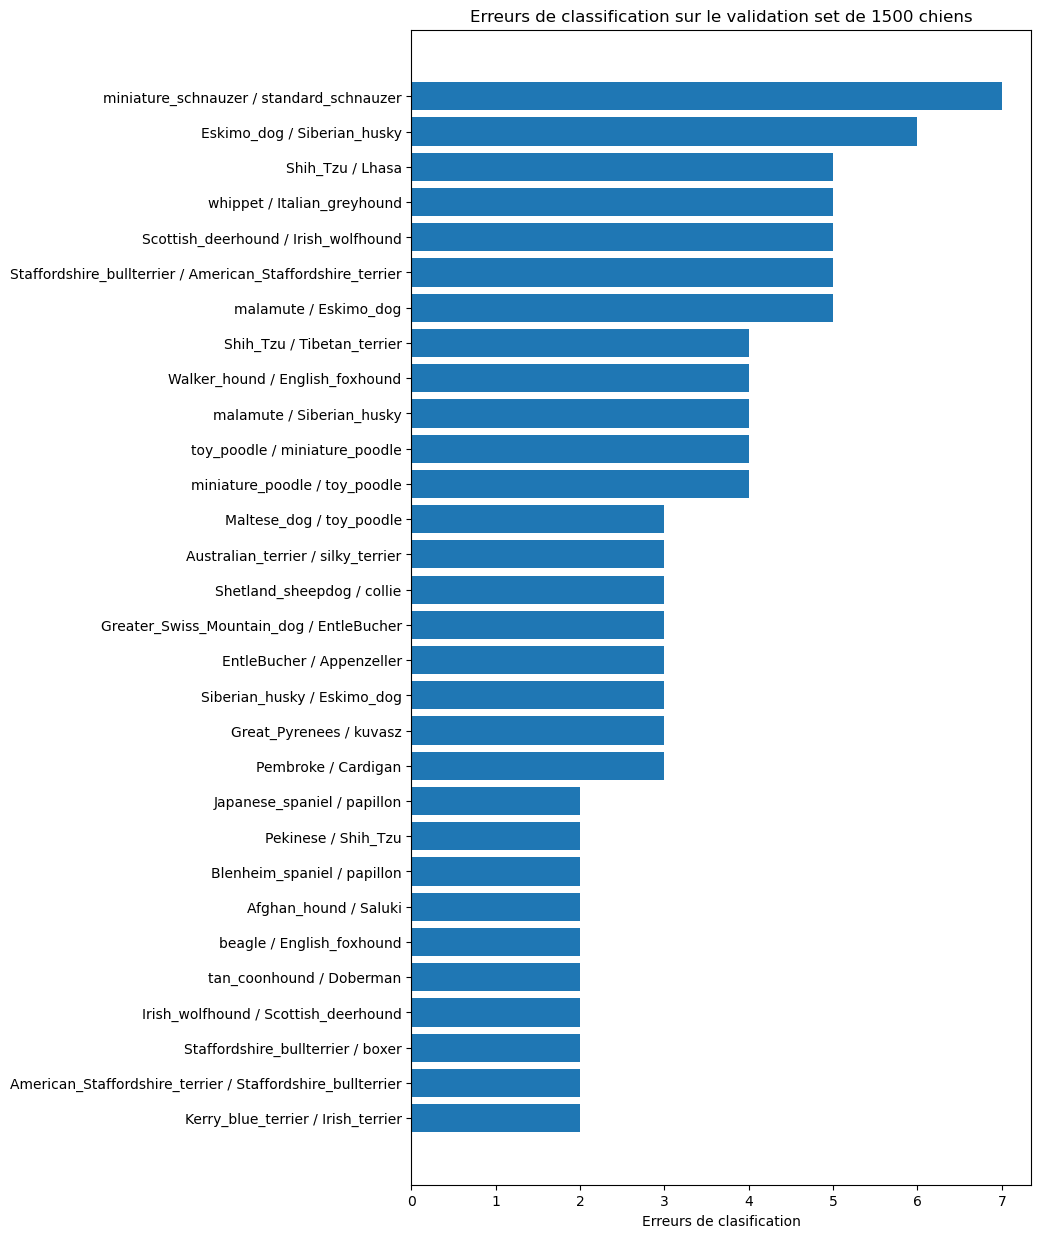

In [146]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (8, 15))

sort_orders = sorted(dict.items(), key=lambda x: x[1], reverse=True)
couples = np.array(sort_orders[:30])[:,0]
erreurs = np.array(sort_orders[:30])[:,1].astype(int)
y_pos = np.arange(len(couples))
#for i in sort_orders:
	#print(i[0], i[1])


ax.barh(couples, erreurs , align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(couples)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Erreurs de clasification')
ax.set_title('Erreurs de classification sur le validation set de 1500 chiens')

plt.show()

In [149]:
from sklearn.metrics import classification_report, confusion_matrix
def clas_report(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    # Classification Report
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    class_report = classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys())
    print('Classification Report')
    print(class_report)
    return clas_report

In [151]:

report = clas_report(new_model,images,labels2,races_dict)

Classification Report
                                precision    recall  f1-score   support

                     Chihuahua       0.85      1.00      0.92        11
              Japanese_spaniel       0.85      0.92      0.88        12
                   Maltese_dog       0.75      1.00      0.86        21
                      Pekinese       0.62      0.91      0.74        11
                      Shih_Tzu       0.42      0.57      0.48        14
              Blenheim_spaniel       0.85      0.92      0.88        12
                      papillon       1.00      0.76      0.87        17
                   toy_terrier       0.92      0.86      0.89        14
           Rhodesian_ridgeback       0.89      0.57      0.70        14
                  Afghan_hound       0.87      0.87      0.87        15
                        basset       0.92      0.92      0.92        12
                        beagle       0.75      0.80      0.77        15
                    bloodhound       0.91

<function __main__.clas_report(model, valid_dataset, valid_labels, dog_race_dict={'Bedlington_terrier': 0, 'collie': 1, 'Greater_Swiss_Mountain_dog': 2, 'bull_mastiff': 3, 'flat_coated_retriever': 4, 'Leonberg': 5, 'affenpinscher': 6, 'English_foxhound': 7, 'kuvasz': 8, 'tan_coonhound': 9})>